In [1]:
import numpy as np
import networkx as nx
import math
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import seaborn as sn
import pandas as pd
import networkx as nx

## Monge formulation

Let $X: \Omega_{X} \rightarrow \mathbb{R}$ and $Y: \Omega_{Y} \rightarrow \mathbb{R}$ be two discrete random variables with $\Omega_{X} = \Omega_{Y} = [1, \ldots, N]$, the Monge formulation of the optimal transport problem is

$$ \begin{array}{c}\text{min}\\ \sigma \in \Pi_{N}\end{array}
\left\{ \sum_{i=1}^{N} C_{i},\sigma(i) \right\}$$

where $\Pi_{N}$ is the set of all the permutation matrices of $\{1, \ldots, N\} \text{x} \{1, \ldots, N\}$, $\sigma \in \Pi_{N}$ a permutation matrix and $\sigma(i)$ the ith row of $\sigma$.

## The Monge fomulation doesn't always have a solution

Suppose there are N bakeries and N cafeterias and a bakery can supply only one cafeteria.
Each bakery produces $x_{i}$ cakes and each cafeteria requires $y_{i}$ cakes s.t. $\sum_{i}x_{i} = \sum_{j} y_{j}$.

In [2]:
N = 6
x = np.array([24., 9., 3., 16., 21., 27.])
y = np.array([3., 23., 18., 26., 16., 14.])

In [3]:
x.sum()

100.0

In [4]:
y.sum()

100.0

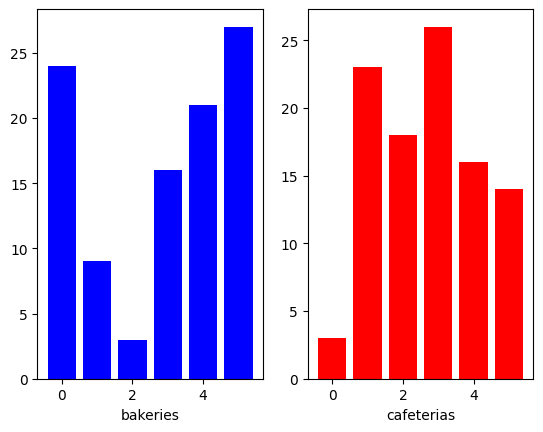

In [5]:
fig, axes = plt.subplots(1, 2);
axes[0].bar(range(N), x, color = "blue")
axes[0].set_xlabel("bakeries")
axes[1].bar(range(N), y, color = "red", label = "x")
axes[1].set_xlabel("cafeterias")
plt.show()

The problem doesn't have a solution in the Monge formulation. However it can be solved if we relax the constraints and each bakery can supply more than one cafeterias.

## Relaxing the Monge formulation : Kantorovich formulation

Assume that a bakery can deliver cakes to any cafeteria. Now we are interested in finding a matrix $M$ with values in $[0, 1]$ and all the rows and the columns sum to one. $B_{i,j}$ represent the proportion of goods produced by the bakery i and delivered to the cafeteria j.

$$M \in \textbf{B}_{N} = \left\{ P \in \mathbb{R}^{N\text{x}N}_{+} : \sum_{i}P_{i,j}=1 \, \sum_{j}P_{i,j}=1 \right\}$$

where $\textbf{B}_{N}$ is the set of all the bistochastic matrices in $R^{N\text{x}N}$

The kantorovich formulation of the optimal transport problem is

$$
\begin{array}{c} \text{min}\\P \in \textbf{B}_{N}\end{array}
\left\{ \sum_{i=1}^{N}\sum_{j=1}^{N} P_{i,j}C_{i,j}\right\}
$$

Let $P_{ij} = \frac{Z_{ij}}{\sum_{ij} Z_{ij}}$ where $Z \in \textbf{N}^{N\text{x}N}$

$$
\begin{array}{c}
    \begin{array}{c} \text{min}\\P \in \textbf{B}_{N}\end{array}
    \left\{ \sum_{i=1}^{N}\sum_{j=1}^{N} P_{i,j}C_{i,j}\right\}
    &
    \equiv
    \begin{array}{c} \text{min}\\Z \in \textbf{N}^{N\text{x}N}\end{array}
    \left\{ \sum_{i=1}^{N}\sum_{j=1}^{N} Z_{i,j}C_{i,j} : Z_{i,j} \geq 0 \right\}
\end{array}
$$

which can be solved by the following integer linear program 

$$
\begin{align}
\text{min} \big\{ <c, z> : p \geq 0, Az = b\big\}
\end{align}
$$

where c is the vectorized cost matrix C, z is the vectorized matrix Z,
 $A = \left[
\begin{array}{c}
I_{N} \otimes 1_{1\text{x}N}\\
1_{1\text{x}N} \otimes I_{N}
\end{array}
\right]$
and $b=\left[\begin{array}{c}x\\ y \end{array}\right]$

**Solving the problem with scipy**

In [6]:
Ax = np.kron(np.identity(N), np.ones(N))
Ax.shape

(6, 36)

In [7]:
Ay = np.kron(np.ones(N), np.identity(N))
Ay.shape

(6, 36)

In [8]:
A = np.concatenate((Ax, Ay), 0)
A.shape

(12, 36)

In [9]:
b = np.concatenate((x, y))
b.shape

(12,)

In [10]:
C = np.array([[12., 10., 31., 27., 10., 30.],
              [22.,  7., 25., 15., 11., 14.],
              [19.,  7., 19., 10., 15., 15.],
              [10.,  6., 21., 19., 14., 24.],
              [15., 23., 14., 24., 31., 34.],
              [35., 26., 16.,  9., 34., 15.]])
c = C.reshape(N * N)

In [11]:
res = linprog(c, A_eq = A, b_eq = b, method = 'simplex')

/tmp/ipykernel_11477/1978926522.py:1: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(c, A_eq = A, b_eq = b, method = 'simplex')
/tmp/ipykernel_11477/1978926522.py:1: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  res = linprog(c, A_eq = A, b_eq = b, method = 'simplex')


**Visual checking**

The solution of the integer linear program is 

In [12]:
z = res.x

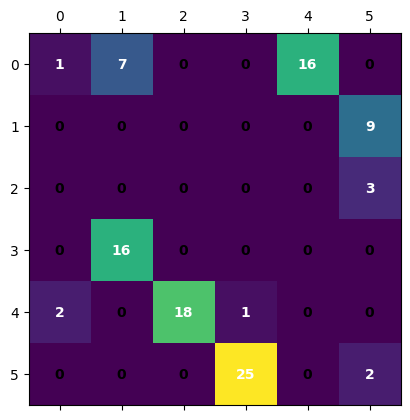

In [13]:
Z = z.reshape((N, N))
plt.matshow(Z)
for i in range(N):
    for j in range(N):
        color = 'white' if Z[i,j] > 0 else 'black'
        plt.text(j,i, int(Z[i,j]), horizontalalignment = 'center',
            verticalalignment = 'center', weight = 'bold', color = color)
plt.show()

The bakery 0 should deliver 1 cake to the the cafeteria 0, 7 cakes to the cafeteria 1, 
and 16 cakes to the cafeteria 4.

The bakery 1 should deliver all its 9 cakes to the cafeteria 5, and so on ...

In [14]:
g = nx.Graph()

In [15]:
nodes_x = ['x' + str(i) for i in range(N)]
nodes_y = ['y' + str(i) for i in range(N)]
# Adding the nodes
for n in nodes_x + nodes_y:
    g.add_node(n)
# Adding the edges
for i in range(N):
    for j in range(N):
        if (Z[i, j] > 0):
            g.add_edge(nodes_x[i], nodes_y[j], weight=Z[i,j])

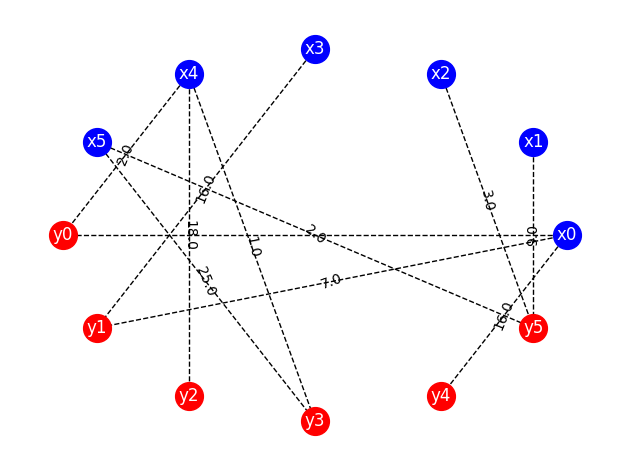

In [16]:
# Drawing the graph
pos = nx.circular_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=nodes_x, node_color = 'blue', node_size = 400)
nx.draw_networkx_nodes(g, pos, nodelist=nodes_y, node_color = 'red', node_size = 400)
nx.draw_networkx_labels(g, pos, font_color = 'w')
edge_labels = nx.get_edge_attributes(g, 'weight')
nx.draw_networkx_edge_labels(g, pos, edge_labels, label_pos=0.5)
nx.draw_networkx_edges(g, pos, style = 'dashed')
plt.axis('off')
plt.tight_layout()
plt.show()

The bistochastic matrix P is $$P_{i,j} = \frac{Z_{i,j}}{\sum_{ij} Z_{i,j}}$$

Its a coupling of $X\text{x}Y$ with joint distributions $f_{X}$ and $f_{Y}$ that minimizes the cost function

In [17]:
P = Z / Z.sum()

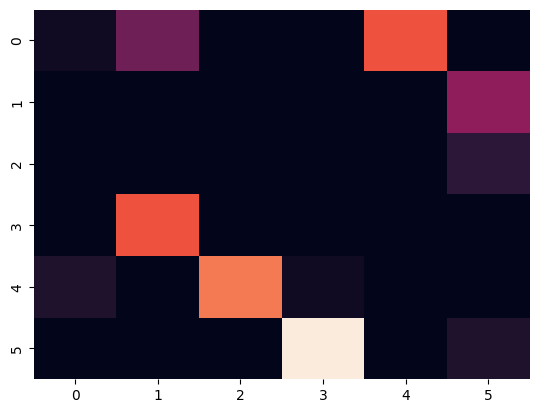

In [18]:
sn.heatmap(P, cbar=False)
plt.show()

The minimum cost is

In [19]:
np.dot(C.flatten(), P.flatten())

10.700000000000001